# 1. Import Dependencies and Setup

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers, metrics

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


# Preprocess Data

In [9]:
data_dir = os.listdir('data')
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
for image_class in os.listdir(os.path.join('data')):
    for image in os.listdir(os.path.join('data', image_class)):
        image_path = os.path.join('data', image_class, image)
        try:
            img = cv2.imread(image_path)
            typ = imghdr.what(image_path)
            if typ not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            print(e)
            # os.remove(image_path)
print('Complete!')

Complete!


# 2. Load and Scale Data

Found 1145 files belonging to 2 classes.


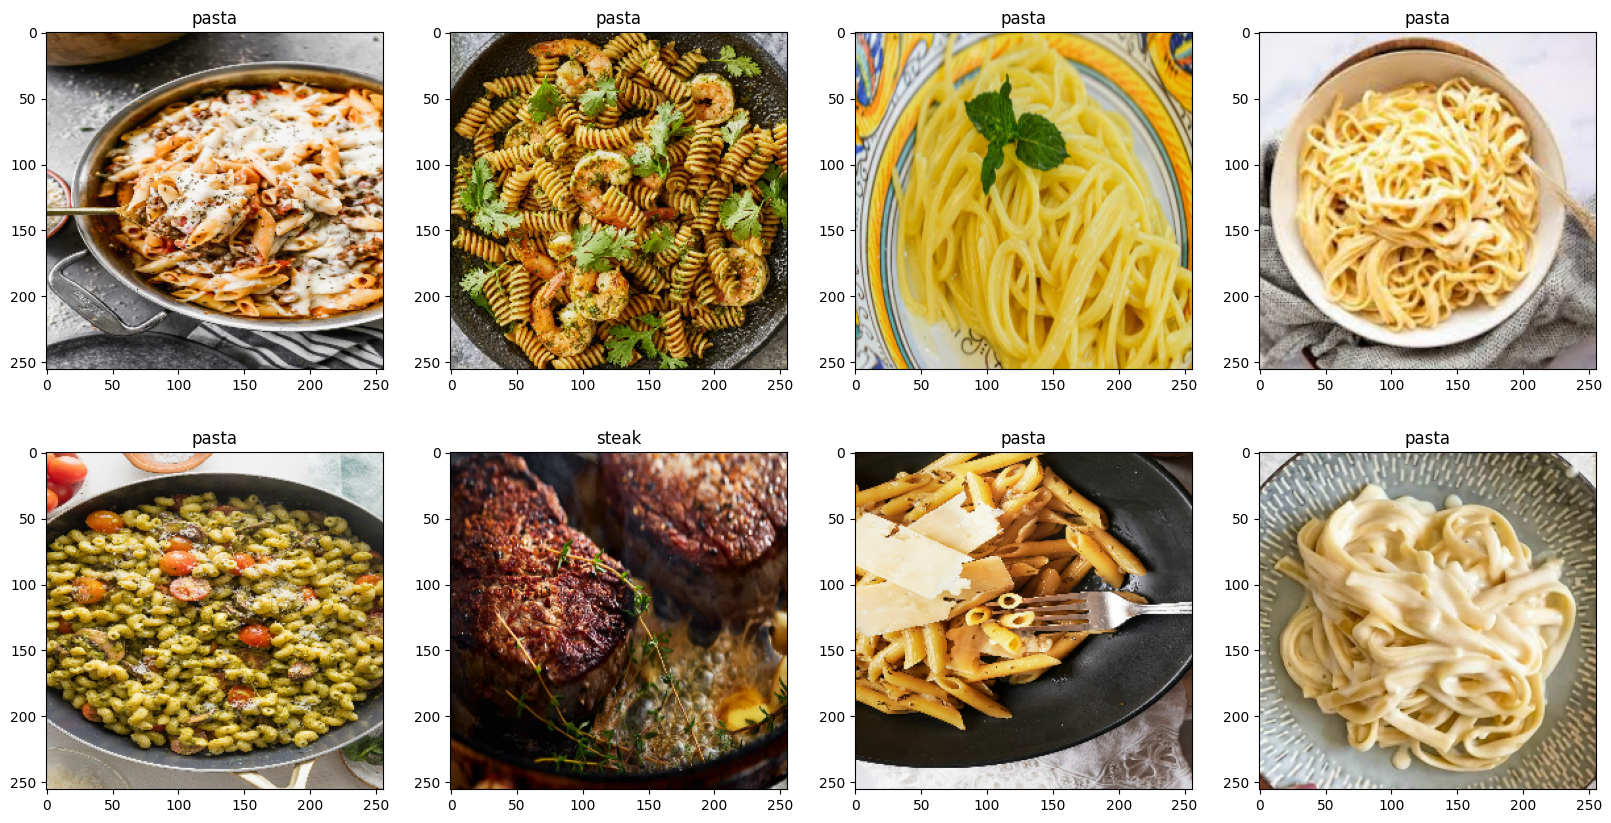

In [4]:
data = tf.keras.utils.image_dataset_from_directory('data', seed=1)
iter = data.as_numpy_iterator()
# batch object has the image at batch[0] in numpy RGB array form, and the corresponding label at batch[1]
batch = iter.next()
labels =  os.listdir('data')

# visualization
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
for i, img in enumerate(batch[0][:8]):
    ax[i//4][i%4].imshow(img.astype(int))
    ax[i//4][i%4].title.set_text(labels[batch[1][i]])
plt.show()

# scale each RGB value to [0,1]
data = data.map(lambda x,y: (x/255, y))

# 3. Split Data

In [5]:
batch_size = len(data)
train_size = int(batch_size *.7)
val_size = int(batch_size *.2)
test_size = int(batch_size *.1)
while(train_size + val_size + test_size != batch_size):
    test_size += 1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 4. Train Model

In [60]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), 1, activation='relu', input_shape=(256,256,3), padding='same'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128, (3, 3), 1, activation='relu'))
model.add(layers.Conv2D(128, (1, 1), 1, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(256, (3, 3), 1, activation='relu'))
model.add(layers.Conv2D(256, (1, 1), 1, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(len(labels), activation='softmax'))

In [61]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 126, 126, 128)     36992     
                                                                 
 conv2d_49 (Conv2D)          (None, 126, 126, 128)     16512     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 63, 63, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 61, 61, 256)     

In [62]:
cb = tf.keras.callbacks.TensorBoard(log_dir='logs')
hist = model.fit(train, epochs=10, validation_data=val, callbacks=cb)

Epoch 1/10
25/25 [==============================] - 7s 201ms/step - loss: 1.8288 - accuracy: 0.6475 - val_loss: 0.6009 - val_accuracy: 0.7098
Epoch 2/10
25/25 [==============================] - 6s 217ms/step - loss: 0.5283 - accuracy: 0.7375 - val_loss: 0.4056 - val_accuracy: 0.7812
Epoch 3/10
25/25 [==============================] - 6s 217ms/step - loss: 0.2850 - accuracy: 0.8788 - val_loss: 0.1466 - val_accuracy: 0.9420
Epoch 4/10
25/25 [==============================] - 6s 218ms/step - loss: 0.1918 - accuracy: 0.9212 - val_loss: 0.1227 - val_accuracy: 0.9509
Epoch 5/10
25/25 [==============================] - 6s 219ms/step - loss: 0.1798 - accuracy: 0.9287 - val_loss: 0.1922 - val_accuracy: 0.9375
Epoch 6/10
25/25 [==============================] - 6s 214ms/step - loss: 0.1308 - accuracy: 0.9525 - val_loss: 0.0936 - val_accuracy: 0.9821
Epoch 7/10
25/25 [==============================] - 6s 218ms/step - loss: 0.1282 - accuracy: 0.9513 - val_loss: 0.1055 - val_accuracy: 0.9464
Epoch 

In [63]:
model.save(os.path.join('models', 'model.h5'))

# Testing

1/1 [==============================] - 0s 51ms/step
Accuracy is : 0.9752066115702479


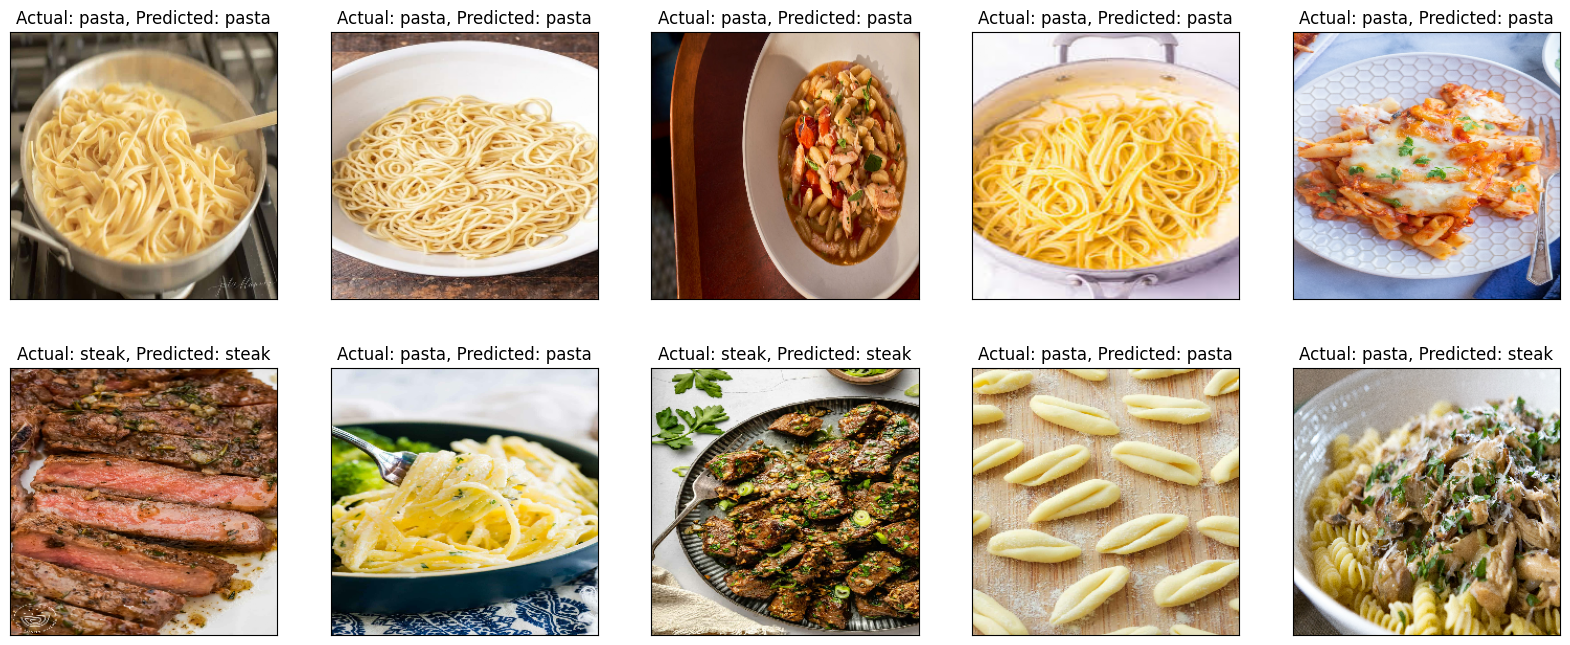

In [12]:
model = models.load_model(os.path.join('models', 'model.h5'))

fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(20,8))

df = pd.DataFrame()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    for i in range(10):
        ax[i//5][i%5].imshow(X[i])
        ax[i//5][i%5].title.set_text('Actual: ' + labels[y[i]] + ', Predicted: ' + labels[np.argmax(yhat[i])])
        ax[i//5][i%5].get_xaxis().set_ticks([])
        ax[i//5][i%5].get_yaxis().set_ticks([])
    
    temp = pd.DataFrame({'actual' : y.tolist(), 'prediction' : yhat.tolist()})
    temp['prediction'] = temp['prediction'].apply(np.argmax)
    
    df = pd.concat([df, temp], axis=0)
true_count = df[df.actual == df.prediction].shape[0]
acc = true_count / df.shape[0]
print('Accuracy is :', acc)